In [ ]:
!pip install tqdm

In [ ]:
import zipfile
import os

folder_name = "/content/sitting posture.v4-sitting_posture_4keypoint.yolov5pytorch.zip"  # Change this to your uploaded zip file
with zipfile.ZipFile(folder_name, 'r') as zip_ref:
    zip_ref.extractall("unzipped_folder")  # Extracted folder name

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from sklearn.cluster import KMeans
import shutil

# Define paths
train_folder = r"/content/unzipped_folder/train"
image_folder = os.path.join(train_folder, "images")  # Images inside "train/images"

processed_folder = r"/content/unzipped_folder/processed_train"
good_folder = os.path.join(processed_folder, "good")
bad_folder = os.path.join(processed_folder, "bad")

# Create folders if they don't exist
os.makedirs(processed_folder, exist_ok=True)
os.makedirs(good_folder, exist_ok=True)
os.makedirs(bad_folder, exist_ok=True)

# Load model
base_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(224, 224, 3))

# Get image paths
image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if images exist
if len(image_paths) == 0:
    print("❌ No images found in train/images/. Check the folder path.")
    exit()


In [ ]:
features = []
valid_images = []

for img_path in image_paths:
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Resize
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)

        feat = base_model.predict(img_array).flatten()

        if feat.shape[0] > 0:  # Only add non-empty features
            features.append(feat)
            valid_images.append(img_path)

    except Exception as e:
        print(f"❌ Skipping {img_path}: {e}")

print(f"✅ Total valid images processed: {len(valid_images)}")
print(f"✅ Total extracted feature vectors: {len(features)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/ste

In [ ]:
if len(features) == 0:
    print("❌ No valid features extracted. Exiting.")
    exit()

# Convert to NumPy array
features = np.array(features)
print(f"Feature array shape: {features.shape}")

# Apply K-Means clustering (2 clusters)
kmeans = KMeans(n_clusters=2, random_state=42)
labels = kmeans.fit_predict(features)

# Move images based on cluster labels
for img_path, label in zip(valid_images, labels):
    file_name = os.path.basename(img_path)

    if label == 0:
        dest_path = os.path.join(good_folder, file_name)
    else:
        dest_path = os.path.join(bad_folder, file_name)

    shutil.move(img_path, dest_path)  # Move file

print(f"✅ Images successfully moved to '{processed_folder}' in 'good' and 'bad' folders!")


Feature array shape: (573, 1280)
✅ Images successfully moved to '/content/unzipped_folder/processed_train' in 'good' and 'bad' folders!


In [ ]:
print(f"Good images: {len(os.listdir(good_folder))}")
print(f"Bad images: {len(os.listdir(bad_folder))}")


Good images: 337
Bad images: 236


In [ ]:
import pandas as pd

data = []
for file_name in os.listdir(good_folder):
    data.append([file_name, "good"])
for file_name in os.listdir(bad_folder):
    data.append([file_name, "bad"])

df = pd.DataFrame(data, columns=["Image", "Category"])
df.to_csv("image_classification_results.csv", index=False)
print("📂 CSV Report saved: image_classification_results.csv")


📂 CSV Report saved: image_classification_results.csv


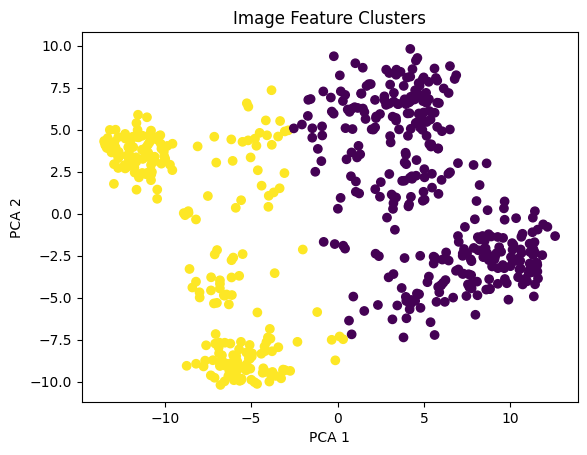

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=labels, cmap="viridis")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Image Feature Clusters")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [ ]:
# Define directories
train_dir = "/content/unzipped_folder/processed_train"  # Root directory with 'good/' and 'bad/'

# Image Data Generator for preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize images
    validation_split=0.2  # Split 80% training, 20% validation
)

# Load training images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images
    batch_size=32,
    class_mode="binary",  # Binary classification (good/bad)
    subset="training"
)

# Load validation images
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)


Found 459 images belonging to 2 classes.
Found 114 images belonging to 2 classes.
Found 459 images belonging to 2 classes.
Found 114 images belonging to 2 classes.


In [ ]:
# Define CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(128, activation="relu"),
    Dropout(0.5),  # Prevent overfitting
    Dense(1, activation="sigmoid")  # Output layer (1 neuron for binary classification)
])

# Compile the model
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Show summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.6507 - loss: 0.6045 - val_accuracy: 0.7719 - val_loss: 0.4013
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9385 - loss: 0.1465 - val_accuracy: 0.9737 - val_loss: 0.1792
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.9648 - loss: 0.0906 - val_accuracy: 0.9561 - val_loss: 0.1600
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9874 - loss: 0.0456 - val_accuracy: 0.9737 - val_loss: 0.1158
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.9814 - loss: 0.0354 - val_accuracy: 0.9737 - val_loss: 0.1476
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9974 - loss: 0.0135 - val_accuracy: 0.9737 - val_loss: 0.1336
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.9962 - loss: 0.0068 - val_accuracy: 0.9737 - val_loss: 0.1452
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 65s 4s/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.9649 - val_loss:

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"📊 Validation Accuracy: {val_acc * 100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9672 - loss: 0.3097
📊 Validation Accuracy: 96.49%


In [ ]:
# Save model
model.save("posture_model.h5")

# Load model
loaded_model = tf.keras.models.load_model("posture_model.h5")


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess new image
def predict_posture(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = loaded_model.predict(img_array)[0][0]

    if prediction > 0.5:
        print("🟢 Good Posture")
    else:
        print("🔴 Bad Posture")

# Example usage
predict_posture("/content/unzipped_folder/processed_train/bad/bad_posture_20241012_172107_png.rf.60103f979a2b233515d7e6b699b97b95.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
🔴 Bad Posture


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load and preprocess new image
def predict_posture(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = loaded_model.predict(img_array)[0][0]

    if prediction > 0.5:
        print("🟢 Good Posture")
    else:
        print("🔴 Bad Posture")

# Example usage
predict_posture("/content/unzipped_folder/processed_train/good/good_posture_20241012_174401_png.rf.0f6e06ae18bddb1336e4398fb49f112e.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
🟢 Good Posture
